---
title: Image dose
---

In [1]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import chain, product
from functools import reduce
import colorspacious

from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import (
    Select,
    SelectMultiple,
    IntSlider,
    ToggleButton,
    FloatRangeSlider,
    Label,
    Layout,
)

from IPython.display import display
from ipywidgets import HBox, VBox

plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.title_fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

In [2]:
def reduction(series, mode):
    match mode:
        case "mean":
            return series.mean()
        case "min":
            return series.min()
        case "max":
            return series.max()
        case "median":
            return series.median()
        case _:
            return ValueError


def weight_freezing_select():
    return SelectMultiple(
        options=["none", "decoder", "encoder"],
        value=["none", "decoder", "encoder"],
        # description="Weight freezing",
        rows=3,
        disabled=False,
        layout={"width": "100px"},
    )


def reduction_select():
    return Select(
        options=["min", "mean", "median", "max"],
        value="mean",
        rows=4,
        # description="Data Reduction",
        disabled=False,
        layout={"width": "100px"},
    )

In [3]:
def history_parser(history):

    def array_iter(epochkeys, subkey):
        for ek in epochkeys:
            yield history[ek][subkey]

    ## Get arrays
    N_epochs = 10
    skeys = [str(x) for x in sorted(int(x) for x in history.keys())]
    array_dict = {
        k: np.fromiter(array_iter(skeys, k), float, count=N_epochs)
        for k in history[str(skeys[0])]
    }

    return {**array_dict}

def get_plot_data(df, reduction_mode):
    p_heatmap = np.zeros((5,5))
    t_heatmap = np.zeros((5,5))
    doses = (30, 75, 150, 300, 600)
    for i, starting_dose in enumerate(doses):
        p_df = df.query(f"pretrain_dose == {starting_dose}")
        for j, transfer_dose in enumerate(doses):
            p_heatmap[i, j] = reduction(p_df[f'best_pretrain_performance_validation_{transfer_dose}'], reduction_mode)
            
            t_df = p_df.query(f"transfer_dose=={transfer_dose}")
            if len(t_df) > 0:
                t_heatmap[i, j] = reduction(t_df[f'best_transfer_performance_validation_{transfer_dose}'], reduction_mode)
            else:
                t_heatmap[i, j] = p_heatmap[i, j]

    return p_heatmap, t_heatmap


In [4]:
with open('tl_noise_models.pkl', 'rb') as f:
    noise_df = pickle.load(f)

for i, row in noise_df.iterrows():
    pretrain_history = row['pretrain_history']
    pretrain_key = row['pretrain_dose']

    best_pretrain_epoch = np.argmin(pretrain_history[f'validation_{pretrain_key}'])
    for k, v in pretrain_history.items():
        if 'validation' in k:
            noise_df.loc[i, f'best_pretrain_performance_{k}'] = np.array(v)[best_pretrain_epoch]

    transfer_history = row['transfer_history']
    transfer_key = row['transfer_dose']

    best_transfer_epoch = np.argmin(transfer_history[f'validation_{transfer_key}'])
    for k, v in transfer_history.items():
        if 'validation' in k:
            noise_df.loc[i, f'best_transfer_performance_{k}'] = np.array(v)[best_pretrain_epoch]

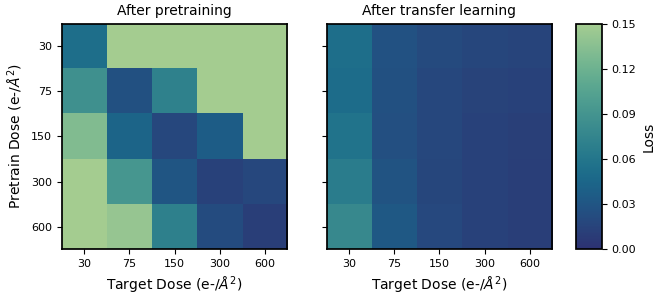

In [5]:
# | label: app:noise_widget


ratio = 2.2
height = 3
fig_style = {'figsize':(ratio * height, height), # inches
            'constrained_layout':True,
            }

fig = plt.figure(**fig_style)

N_per_mat = 10
gs = fig.add_gridspec(1,N_per_mat*2 + 1)
ax_p = fig.add_subplot(gs[:N_per_mat])
ax_t = fig.add_subplot(gs[N_per_mat:-1])
ax_cbar = fig.add_subplot(gs[-1])

cmap = sns.color_palette('crest_r', as_cmap=True)
pmin = 0.0
pmax = 0.15

freeze_select = weight_freezing_select()
rmode_select = reduction_select()

center_align = Layout(align_items="center")
freeze_box = VBox([Label("Weight Freezing"), freeze_select], layout=center_align)
rmode_box = VBox([Label("Reduction Mode"), rmode_select], layout=center_align)

full_box = HBox([freeze_box, rmode_box])
display(full_box)


def update_plot(*args):
    weight_freezing = freeze_select.value
    reduction_mode = rmode_select.value

    local_df = noise_df.query(f"freezing_mode in {weight_freezing}")
    p_heatmap, t_heatmap = get_plot_data(local_df, reduction_mode)
    cim = ax_p.matshow(p_heatmap - 0.3133, cmap=cmap, vmin=pmin, vmax=pmax)
    ax_t.matshow(t_heatmap - 0.3133, cmap=cmap, vmin=pmin, vmax=pmax)

    fig.colorbar(cim, cax=ax_cbar)

    ax_t.set_yticklabels([])

    ax_p.set_xlabel("Target Dose (e-/$\\AA^2$)")
    ax_p.set_ylabel("Pretrain Dose (e-/$\\AA^2$)",)
    ax_t.set_xlabel("Target Dose (e-/$\\AA^2$)")
    ax_p.xaxis.set_ticks_position('bottom')
    ax_t.xaxis.set_ticks_position('bottom')

    ax_p.set_title('After pretraining', fontsize=10)
    ax_t.set_title('After transfer learning', fontsize=10)

    ax_p.set_xticks([0,1,2,3,4], [30, 75, 150, 300, 600])
    ax_p.set_yticks([0,1,2,3,4], [30, 75, 150, 300, 600])
    ax_t.set_xticks([0,1,2,3,4], [30, 75, 150, 300, 600])

    ax_cbar.set_ylabel("Loss")
    ax_cbar.set_yticks(np.arange(6)*pmax/5)


    for ax in [ax_t, ax_p, ax_cbar]:
        _ = plt.setp(ax.spines.values(), linewidth=1.25)

update_plot()
freeze_select.observe(update_plot, "value")
rmode_select.observe(update_plot, "value")